# V - Calculating areas of change and confidence intervals
### This script serves to perform a quick estimation of areas and confidence intervals for all types of change using validated data
### This script requires a m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

### 1 - Read files

In [2]:
def calculate_areas(df_merged, kozak_column, target_column, total_area):
    
    df_full = df_merged.copy()
    df_merged = df_merged[df_merged['interpreted'] == 1]
    
    # get all attributes
    categories = df_merged[target_column].unique()
    print(categories)
    # get strata
    strata, d = df_merged[kozak_column].unique(), {}
    
    # create stats for each entry
    for category in categories:
        
        if str(category) == 'nan':
            continue
            
        print(f' Calculating stats for {category}')
        # create binary class column
        df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)
        print(f'There are {df_merged[category].sum()} entries of {category} in {target_column}.')
        
        # initialize variables for category
        categories_area, se_total = 0, 0
        d2 = {}
        for stratum in strata:
                        
            if str(stratum) == 'nan':
                continue
            
            # subset to stratum
            strat_df = df_full[df_full[kozak_column] == stratum]
            
            # get area proportion for that stratum on full dataset
            proportion_strata = len(strat_df)/len(df_full)

            # get stratum area
            stratum_area = proportion_strata * total_area

            # get proportion of forest change within strata from interpreted data
            proportion_category = len(
                df_merged[(df_merged[kozak_column] == stratum) & (df_merged[category] == 1)]
            ) / len(
                df_merged[df_merged[kozak_column] == stratum]
            )
            
            # get area from proportion and full area
            area = proportion_category * stratum_area

            # get error from interpreted data for full stratum area
            var = np.var(df_merged[category][df_merged[kozak_column] == stratum]) / len(df_merged[df_merged[kozak_column] == stratum])
            se = np.sqrt(var) * stratum_area

            # add for totals
            categories_area += area
            se_total += se**2
            
            # add to dictionary
            d2[f'area_stratum_{stratum}'] = area
            d2[f'ci_stratum_{stratum}']=1.67*se
        
        d2['area_total'] = categories_area
        d2['ci_total'] = 1.67*np.sqrt(se_total)
        d2['perc_error'] = np.sqrt(se_total) / categories_area * 100
        d[category] = d2
    
    
    return pd.DataFrame.from_dict(d, orient='index')

### point to the output merged file from the previous script

In [3]:
df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_merge.csv', low_memory=False)

In [4]:
df.columns

Index(['Unnamed: 0', 'point_id', 'plotid', 'lat', 'lon', 'stratum', 'chg_prob',
       'simple_combined', 'NOM', 'interpreted', 'sampleid', 'email', 'flagged',
       'collection_time', 'analysis_duration', 'sample_geom',
       'forêt ou non-forêt en 2015?', 'Y'a t'il de la régéneration',
       'Changement entre 2015-2022', 'Type de Changement (2015-2022)',
       'Exploitation forestière artisanale (<5ha)',
       'Activité minière artisanale', 'Infrastructure routière',
       'Infrastructure d’urbanisation ou habitations',
       'Exploitation forestière industrielle (>5ha)', 'Autre moteur',
       'Descriptif autre moteur', 'Activité minière industrielle',
       'Agriculture industrielle', 'Agriculture paysanne',
       'Année de Changement', 'Type de non-forêt en 2015',
       'Type de forêt en 2015', 'Commentaires', 'collection', 'ChangeType',
       'ChangeYear'],
      dtype='object')

In [5]:
print(np.unique(df['ChangeYear'].astype(str), return_counts=True))
print(len(df))

(array(['Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021',
       'Def2022', 'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020',
       'Deg2021', 'Deg2022', 'NF', 'Stable', 'nan'], dtype=object), array([     52,      63,      58,      79,      78,      57,      42,
            51,      11,      14,      26,      23,      16,      14,
          4025,    2479, 1543020]))
1550108


### calculate for all years

In [6]:
interpreted = [
    'Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021', 'Def2022',
    'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020', 'Deg2021',
    'Deg2022', 'NF', 'Stable'
]

#df['interpreted'] = df['ChangeYear'].apply(lambda x: 1 if str(x) in interpreted else 0)
df['accumulated'] = df['ChangeYear'].apply(
    lambda x: 'Deforestation' if str(x).startswith('Def') else 'Degradation' if str(x).startswith('Deg') else 'Stable' if str(x).startswith('Sta') else 'NF')
#stas_df = calculate_areas(df, 'Strata', 'ChangeYear', 26287600).sort_index()
stats_gdf = calculate_areas(df, 'stratum', 'accumulated', len(df)*118).sort_index()
#stats_df = calculate_areas(df, 'stratum', 'ChangeYear', len(df)*118).sort_index()

['Stable' 'NF' 'Degradation' 'Deforestation']
 Calculating stats for Stable
There are 2479 entries of Stable in accumulated.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for NF
There are 4025 entries of NF in accumulated.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Degradation
There are 155 entries of Degradation in accumulated.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deforestation
There are 429 entries of Deforestation in accumulated.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


In [7]:
np.unique(df['accumulated'], return_counts=True)

(array(['Deforestation', 'Degradation', 'NF', 'Stable'], dtype=object),
 array([    429,     155, 1547045,    2479]))

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
stats_gdf[['area_total', 'ci_total', 'perc_error']]
stats_gdf['ChangeYear'] = stats_gdf.index

In [9]:
stats_gdf

,area_stratum_1,ci_stratum_1,area_stratum_2,ci_stratum_2,area_stratum_3,ci_stratum_3,area_total,ci_total,perc_error,ChangeYear
Deforestation,0.000,0.000,1191243.148,237185.847,2275542.671,189129.292,3466785.819,303359.547,5.240,Deforestation
Degradation,604650.594,1006701.943,621518.164,172121.861,745872.320,112613.695,1972041.078,1027500.161,31.200,Degradation
NF,11488361.285,4140303.819,40053392.787,827858.548,10657124.845,304266.529,62198878.916,4233207.249,4.075,NF
Stable,87674336.121,4233289.621,20268397.902,810899.052,7332304.164,290085.532,115275038.187,4320005.544,2.244,Stable


### calculate for each year

In [10]:
interpreted = [
    'Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021', 'Def2022',
    'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020', 'Deg2021',
    'Deg2022', 'NF', 'Stable'
]

df['interpreted'] = df['ChangeYear'].apply(lambda x: 1 if str(x) in interpreted else 0)
#df['accumulated'] = df['ChangeYear'].apply(
#    lambda x: 'Deforestation' if str(x).startswith('Def') else 'Degradation' if str(x).startswith('Deg') else 'Stable' if str(x).startswith('Sta') else 'NF')

#stats_df_group = calculate_areas(df, 'stratum', 'accumulated', len(df)*118).sort_index()
stats_df = calculate_areas(df, 'stratum', 'ChangeYear', len(df)*118).sort_index()

['Stable' 'NF' 'Deg2020' 'Def2021' 'Def2016' 'Def2018' 'Deg2019' 'Def2020'
 'Def2022' 'Def2019' 'Deg2022' 'Def2017' 'Deg2018' 'Deg2017' 'Deg2021'
 'Deg2016']
 Calculating stats for Stable
There are 2479 entries of Stable in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for NF
There are 4025 entries of NF in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2020
There are 23 entries of Deg2020 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2021
There are 57 entries of Def2021 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2016
There are 52 entries of Def2016 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2018
There are 58 entries of Def2018 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2019
There are 26 entries of Deg2019 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2020
There are 78 entries of Def2020 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2022
There are 42 entries of Def2022 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2019
There are 79 entries of Def2019 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2022
There are 14 entries of Deg2022 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Def2017
There are 63 entries of Def2017 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2018
There are 14 entries of Deg2018 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2017
There are 11 entries of Deg2017 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2021
There are 16 entries of Deg2021 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2016
There are 51 entries of Deg2016 in ChangeYear.


/tmp/ipykernel_5243/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


In [11]:
stats_df

,area_stratum_1,ci_stratum_1,area_stratum_2,ci_stratum_2,area_stratum_3,ci_stratum_3,area_total,ci_total,perc_error
Def2016,0.000,0.000,120850.754,76206.858,284442.834,70330.776,405293.588,103701.029,15.321
Def2017,0.000,0.000,138115.148,81457.217,347652.353,77634.945,485767.500,112527.610,13.871
Def2018,0.000,0.000,103586.361,70563.661,328689.497,75522.571,432275.858,103358.062,14.317
Def2019,0.000,0.000,189908.328,95477.147,429824.727,86151.948,619733.055,128600.325,12.426
Def2020,0.000,0.000,207172.721,99708.730,417182.823,84901.616,624355.544,130958.448,12.560
Def2021,0.000,0.000,189908.328,95477.147,290763.786,71097.092,480672.114,119040.674,14.830
Def2022,0.000,0.000,241701.508,107667.709,176986.652,55621.291,418688.160,121186.070,17.332
Deg2016,0.000,0.000,86321.967,64424.478,290763.786,71097.092,377085.753,95944.306,15.236
Deg2017,0.000,0.000,51793.180,49916.870,50567.615,29820.897,102360.795,58146.193,34.015
Deg2018,0.000,0.000,51793.180,49916.870,69530.471,34952.280,121323.651,60937.310,30.076


In [12]:
stats_df['ChangeYear'] = stats_df.index
#stats_df
stats_df.columns

Index(['area_stratum_1', 'ci_stratum_1', 'area_stratum_2', 'ci_stratum_2',
       'area_stratum_3', 'ci_stratum_3', 'area_total', 'ci_total',
       'perc_error', 'ChangeYear'],
      dtype='object')

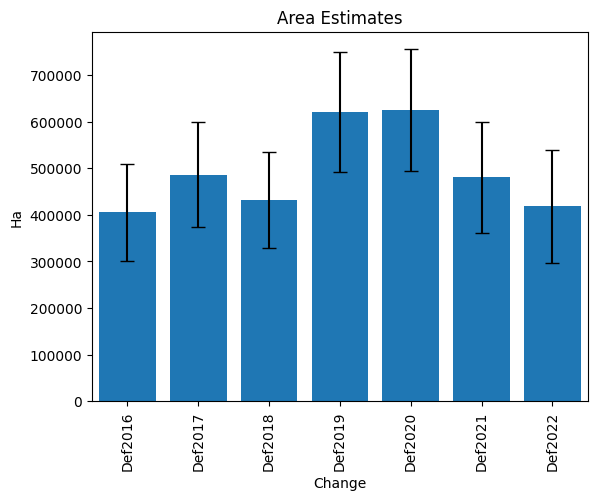

In [13]:
#plot DEF 
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
Def_areas = stats_df[stats_df['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Def_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Def_areas['ChangeYear'], Def_areas['area_total'], yerr=Def_areas['ci_total'], capsize=5)  # Add error bars

# Show the plot
plt.show()

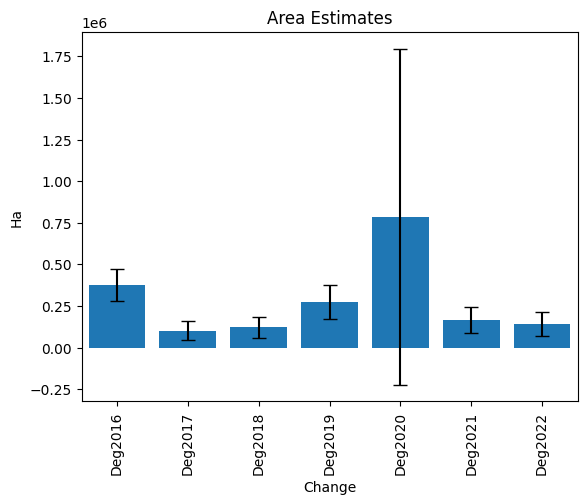

In [14]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
Deg_areas = stats_df[stats_df['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Deg_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Deg_areas['ChangeYear'], Deg_areas['area_total'], yerr=Deg_areas['ci_total'], capsize=5)  # Add error bars
# Show the plot
plt.show()

### export stats to csv

In [ ]:
grouped_out =  '/home/sepal-user/module_results/esbae/DRC/DRC_total_stats_2015_2022.csv'
stats_gdf.to_csv(grouped_out,index=True)

In [ ]:
annual_out =  '/home/sepal-user/module_results/esbae/DRC/DRC_annual_stats_2015_2022.csv'
stats_df.to_csv(annual_out,index=True)